In [1]:
import numpy as np
from pathlib import Path
import SimpleITK as sitk
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from totalsegmentator.python_api import totalsegmentator

Se definen el path del dataset y de los volúmenes y las máscaras de segmentación.

In [2]:
dataset_path = Path("/home/data/kaggle-spine-seg/spine_segmentation_nnunet_v2")
volume_paths = list((dataset_path / "volumes").rglob("*.nii"))
mask_paths = list((dataset_path / "segmentations").rglob("*.nii"))

Función para visualizar una slice de un volumen en un eje dado.

Por defecto visualiza la slice del medio del eje sagital.

Es posible que tras correr TotalSegmentator, no se desplieguen los gráficos de matplotlib.

In [19]:
def visualize_case_slice(volume_path, mask_path=None, slice_idx=None, axis=2, figsize=(5,5)):
  volume_path = Path(volume_path)
  if mask_path is None:
    mask_path = Path(str(volume_path).replace("volumes", "segmentations"))
  try:
    volume = sitk.GetArrayFromImage(sitk.ReadImage(volume_path))
    mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
    if slice_idx is None:
      slice_idx = volume.shape[axis]//2
    volume_slice = np.take(volume, indices=slice_idx, axis=axis)[::-1, :]
    mask_slice = np.take(mask, indices=slice_idx, axis=axis)[::-1, :]
    num_classes = int(np.max(mask)) + 1
    colors = plt.cm.viridis(np.linspace(0.1, 0.9, num_classes))
    colors[0, 3] = 0
    for j in range(1, num_classes):
      colors[j, 3] = 1.0
    cmap = ListedColormap(colors)
    case_id = volume_path.name.split(".nii")[0]
    aspect = volume_slice.shape[1]/volume_slice.shape[0]
    plt.figure(figsize=figsize)
    plt.imshow(volume_slice, cmap="gray", interpolation='none', aspect=aspect)
    plt.imshow(mask_slice, cmap=cmap, alpha=0.7, interpolation='none', aspect=aspect)
    plt.title(f"{case_id}", fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
  except Exception as e:
    print(f"Error processing {volume_path}: {e}")

Ejemplo de visualización de un caso particular.

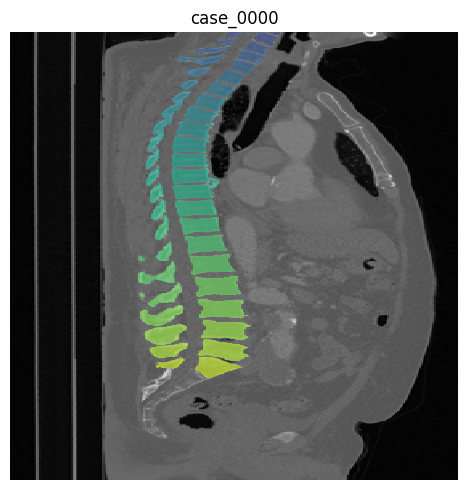

In [22]:
example_volume_path = volume_paths[0]
example_volume_path
visualize_case_slice(example_volume_path)

## Ejemplo de uso de TotalSegmentator

Se definen los órganos a segmentar, en este caso las vértebras que definen el abdomen.

TotalSegmentator recibe el path del archivo a segmentar, y guarda un archivo con la máscara de segmentación generada.

Sobre el uso de TotalSegmentator, se puede encontrar más información en https://github.com/wasserth/TotalSegmentator

In [ ]:
target_organs = [
  'vertebrae_T8',
  'vertebrae_T10',
  'vertebrae_L4',
]

totalsegmentator(
  input=example_volume_path,
  output="./example_ts_output.nii.gz",
  ml=True, # Obtener un solo archivo con todas las estructuras segmentadas, en lugar de un archivo por estructura.
  roi_subset=target_organs,
  fast=True, # Menor tiempo de procesamiento, pero peores resultados
  statistics=False, # Generar archivo json con volumen e intensidad media por órgano segmentado
)


If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024



Visualización de la máscara generada por TotalSegmentator en el slice del medio de la vista sagital.

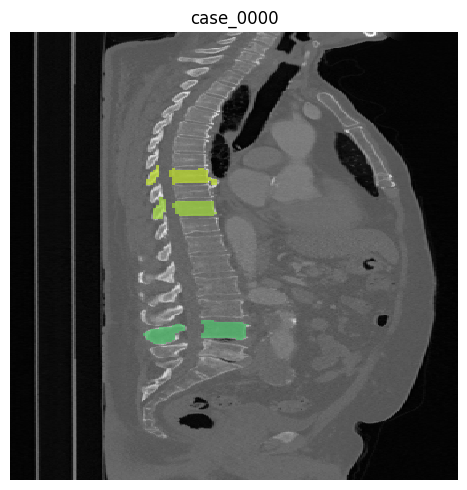

In [23]:
visualize_case_slice(
  volume_path=example_volume_path,
  mask_path="./example_ts_output.nii.gz"
)